# Generating Mood Playlists

In [81]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# allowing all the columns to be visualized
pd.options.display.max_columns = None

# rendering all graphics straight out of the notebook
%matplotlib inline

import warnings
warnings.filterwarnings(action='once')

In [82]:
# visualizations settings
sns.set_theme(style = "whitegrid", font_scale = 1.5)
qual_pal = sns.color_palette('hls', 8)

## Exploring the Dataset

### Why is it important to explore the dataset?
This step is important because it helps us identify patterns and problems in the dataset. More importantly, it **helps us decide what models or algorithms to use in subsequent steps**. REMEMBER: **GARBAGE IN, GARBAGE OUT!**

### Data Exploration Plan
1. Identify and deal with outliers in data
Outliers–observations that have extremely large or small values relative to the majority of observations–can have great impact on results. Not identifying and dealing with them can lead to inaccurate outputs. Boxplots, histograms, violin plots, scatterplots, biplots can be used to detect outliers. 

2. Checking for homogeneity in variances
This is an important assumption in ANOVA, multivariate techniques and regression-based models. 

3. Checking for normally distributed data

4. Checking for missing values in data

5. Checking for multicollinearity (collinearity in covariates)

6. Checking for interaction between variables

7. Checking for independence in data

In [83]:
# importing in main dataset (audio features, genre, track id)
audio_features = pd.read_csv('/Users/huongngo/Desktop/PERSONAL PROJECTS/music_explorer/data/audio_features.csv')
audio_features = audio_features.drop(['Unnamed: 0'], axis = 1)
audio_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,explicit,artist_name,track_popularity
0,0.492,0.791,11,-5.045,1,0.0703,0.00816,0.000019,0.110,0.585,144.363,audio_features,0LJIVYOer8mlCmTrKoP9Kh,spotify:track:0LJIVYOer8mlCmTrKoP9Kh,https://api.spotify.com/v1/tracks/0LJIVYOer8ml...,https://api.spotify.com/v1/audio-analysis/0LJI...,218391,4,jazz,False,Michael Bublé,54
1,0.278,0.354,5,-6.647,0,0.0372,0.50200,0.001240,0.309,0.090,121.803,audio_features,3xZFuVIvzqBImEYJydRkp9,spotify:track:3xZFuVIvzqBImEYJydRkp9,https://api.spotify.com/v1/tracks/3xZFuVIvzqBI...,https://api.spotify.com/v1/audio-analysis/3xZF...,208866,3,jazz,False,Michael Bublé,47
2,0.509,0.457,6,-6.021,1,0.0381,0.39800,0.000000,0.104,0.521,116.472,audio_features,1ugWQPtI7SNYDXqEwuEjVm,spotify:track:1ugWQPtI7SNYDXqEwuEjVm,https://api.spotify.com/v1/tracks/1ugWQPtI7SNY...,https://api.spotify.com/v1/audio-analysis/1ugW...,185531,4,jazz,False,Michael Bublé,52
3,0.401,0.712,8,-4.518,1,0.0300,0.03710,0.001890,0.091,0.561,84.343,audio_features,4BECSdUBaiMX0dNmLHr0kZ,spotify:track:4BECSdUBaiMX0dNmLHr0kZ,https://api.spotify.com/v1/tracks/4BECSdUBaiMX...,https://api.spotify.com/v1/audio-analysis/4BEC...,197755,4,jazz,False,Michael Bublé,53
4,0.506,0.612,11,-6.297,1,0.0607,0.03010,0.000000,0.116,0.527,139.931,audio_features,7zqznhNk8DZbwo8fWIF82V,spotify:track:7zqznhNk8DZbwo8fWIF82V,https://api.spotify.com/v1/tracks/7zqznhNk8DZb...,https://api.spotify.com/v1/audio-analysis/7zqz...,143386,3,jazz,False,Michael Bublé,51


In [84]:
spec_type = ['NU', 'NU', 'NO', 'NU', 'NO', 'NU', 'NU', 'NU', 'NU', 'NU', 'NU', 'STR', 'STR', 'STR', 'STR', 'STR', 'NU', 'NO', 'NO', 'NO', 'STR', 'NU']
data_type = pd.DataFrame(audio_features.dtypes, columns = ['Data Type'])
data_type['Specific Data Type'] = spec_type
data_type.sort_values(by = ['Specific Data Type'])

,Data Type,Specific Data Type
explicit,bool,NO
key,int64,NO
genre,object,NO
mode,int64,NO
time_signature,int64,NO
danceability,float64,NU
duration_ms,int64,NU
valence,float64,NU
tempo,float64,NU
instrumentalness,float64,NU


In [85]:
audio_features['explicit'] = audio_features['explicit'].map({True: 'True', False: 'False'}) 

In [86]:
numeric_columns = list(audio_features.columns[:11]) + list(audio_features.columns[16:18]) + [audio_features.columns[-1]]
string_columns = list(audio_features.columns[11:16]) + list(audio_features.columns[18:20]) + [audio_features.columns[-2]]

In [87]:
# dataset info
audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52897 entries, 0 to 52896
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      52897 non-null  float64
 1   energy            52897 non-null  float64
 2   key               52897 non-null  int64  
 3   loudness          52897 non-null  float64
 4   mode              52897 non-null  int64  
 5   speechiness       52897 non-null  float64
 6   acousticness      52897 non-null  float64
 7   instrumentalness  52897 non-null  float64
 8   liveness          52897 non-null  float64
 9   valence           52897 non-null  float64
 10  tempo             52897 non-null  float64
 11  type              52897 non-null  object 
 12  id                52897 non-null  object 
 13  uri               52897 non-null  object 
 14  track_href        52897 non-null  object 
 15  analysis_url      52897 non-null  object 
 16  duration_ms       52897 non-null  int64 

In [88]:
# descriptive statistics about data
audio_features[numeric_columns].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,52897.000000,5.289700e+04,52897.000000,52897.000000
mean,0.545858,0.593354,5.248804,-9.254906,0.639186,0.094807,0.340417,0.165000,0.229081,0.456094,118.815043,2.313948e+05,3.890221,26.845322
std,0.181316,0.265136,3.606166,5.813155,0.480241,0.125607,0.351263,0.317771,0.213840,0.257094,30.561409,1.232451e+05,0.474021,20.096229
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.339000e+03,0.000000,0.000000
25%,0.420000,0.405000,2.000000,-11.180000,0.000000,0.036000,0.026500,0.000000,0.099000,0.242000,95.003000,1.786270e+05,4.000000,10.000000
50%,0.556000,0.634000,5.000000,-7.608000,1.000000,0.049300,0.186000,0.000104,0.133000,0.442000,117.788000,2.175060e+05,4.000000,25.000000
75%,0.684000,0.814000,8.000000,-5.349000,1.000000,0.093000,0.654000,0.072900,0.288000,0.657000,138.294000,2.661720e+05,4.000000,41.000000
max,0.989000,1.000000,11.000000,0.229000,1.000000,0.965000,0.996000,1.000000,0.999000,0.986000,248.060000,4.497994e+06,5.000000,97.000000


Loudness, acousticness, liveness, duration columns don't seem to be very useful in determining moods. 

Instrumentalness and speechiness seems to be similar features, so we might have to select either one of them, or none of them if they prove to not be useful in determining mood. 

Both tempo and time signature refer to rhythm of the music. We might choose either one of them. 

Track popularity is completely unrelated to mood. 

This leaves the following columns that are potentially good features to keep for clustering: danceability, energy, mode, valence, tempo, key. 

## What are danceable, high/low energy, high/low valence like?

### Danceability

In [89]:
audio_features.loc[audio_features['danceability'] >= 0.5].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,32492.000000,32492.000000,32492.000000,32492.000000,32492.000000,32492.000000,32492.000000,32492.000000,32492.00000,32492.000000,32492.000000,3.249200e+04,32492.000000,32492.000000
mean,0.663341,0.638245,5.352856,-8.064422,0.608057,0.109379,0.274771,0.115623,0.20867,0.545221,117.817002,2.232088e+05,3.949249,27.644189
std,0.104671,0.220878,3.626076,4.302156,0.488191,0.145123,0.300066,0.268197,0.18639,0.236970,26.554915,9.479143e+04,0.330049,20.942943
min,0.500000,0.000142,0.000000,-38.577000,0.000000,0.022200,0.000004,0.000000,0.01280,0.000000,31.898000,1.542800e+04,0.000000,0.000000
25%,0.575000,0.498000,2.000000,-9.768000,0.000000,0.037200,0.029600,0.000000,0.09610,0.361000,97.018000,1.799698e+05,4.000000,9.000000
50%,0.654000,0.672000,6.000000,-7.040000,1.000000,0.055000,0.146000,0.000023,0.13000,0.552000,116.232500,2.145580e+05,4.000000,25.000000
75%,0.739000,0.814000,9.000000,-5.184000,1.000000,0.111000,0.454250,0.011200,0.26600,0.733000,133.154000,2.559870e+05,4.000000,42.000000
max,0.989000,0.998000,11.000000,0.026000,1.000000,0.965000,0.996000,0.985000,0.99600,0.986000,248.060000,4.032163e+06,5.000000,97.000000


In [90]:
audio_features.loc[audio_features['danceability'] <= 0.5].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,2.051300e+04,20513.000000,20513.000000
mean,0.359527,0.522198,5.083459,-11.142770,0.689173,0.071685,0.444588,0.243329,0.261671,0.314577,120.372773,2.443805e+05,3.797299,25.572710
std,0.104167,0.309940,3.567485,7.227742,0.462844,0.080978,0.398146,0.370160,0.248089,0.221708,35.938248,1.572106e+05,0.627362,18.599539
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.339000e+03,0.000000,0.000000
25%,0.291000,0.247000,2.000000,-14.473000,0.000000,0.034900,0.018900,0.000003,0.103000,0.134000,89.877000,1.751330e+05,4.000000,10.000000
50%,0.379000,0.520000,5.000000,-8.996000,1.000000,0.043600,0.380000,0.001700,0.139000,0.273000,120.037000,2.236550e+05,4.000000,24.000000
75%,0.447000,0.817000,8.000000,-5.803000,1.000000,0.067700,0.881000,0.537000,0.330000,0.454000,145.003000,2.878400e+05,4.000000,39.000000
max,0.500000,1.000000,11.000000,0.229000,1.000000,0.932000,0.996000,1.000000,0.999000,0.985000,241.005000,4.497994e+06,5.000000,92.000000


In [91]:
audio_features.loc[audio_features['danceability'] >= 0.5].value_counts(['genre'])

genre      
latin          2311
k-pop          2213
afrobeat       1980
r&b            1907
disco          1894
funk           1885
country        1816
soul           1799
pop            1785
electronic     1721
electronica    1612
rock           1537
hip hop        1343
folk           1302
indie          1290
jazz           1264
blues          1101
christian      1050
punk            962
metal           787
ambient         516
classical       417
dtype: int64

In [92]:
audio_features.loc[audio_features['danceability'] <= 0.5].value_counts(['genre'])

genre      
classical      2030
ambient        1934
metal          1669
punk           1499
christian      1400
blues          1358
jazz           1188
indie          1158
folk           1152
rock            917
electronica     842
electronic      737
pop             666
soul            657
country         648
funk            566
disco           557
r&b             543
afrobeat        470
k-pop           237
hip hop         149
latin           136
dtype: int64

In [93]:
audio_features.loc[audio_features['danceability'] <= 0.5].value_counts(['mode'])

mode
1       14137
0        6376
dtype: int64

In [94]:
audio_features.loc[audio_features['danceability'] >= 0.5].value_counts(['mode'])

mode
1       19757
0       12735
dtype: int64

### Energy

In [95]:
audio_features.loc[audio_features['energy'] >= 0.5].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,34836.000000,34836.000000,34836.000000,34836.000000,34836.000000,34836.000000,34836.000000,34836.000000,34836.000000,34836.000000,34836.000000,3.483600e+04,34836.000000,34836.000000
mean,0.582139,0.754987,5.334482,-6.474197,0.616632,0.098465,0.162885,0.107571,0.252269,0.518466,122.675907,2.379339e+05,3.953697,28.330692
std,0.165082,0.138722,3.627228,2.685129,0.486214,0.099866,0.212046,0.254713,0.229948,0.241764,29.445360,1.184611e+05,0.313163,20.288470
min,0.000000,0.500000,0.000000,-42.642000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,3.339000e+03,0.000000,0.000000
25%,0.471000,0.639000,2.000000,-7.874000,0.000000,0.038800,0.009570,0.000000,0.099600,0.330000,99.250750,1.884405e+05,4.000000,11.000000
50%,0.591000,0.758000,5.000000,-6.098000,1.000000,0.058300,0.066100,0.000032,0.152000,0.522000,120.038000,2.213000e+05,4.000000,27.000000
75%,0.706000,0.872000,9.000000,-4.613000,1.000000,0.113000,0.241000,0.011900,0.327000,0.709000,141.929000,2.661910e+05,4.000000,43.000000
max,0.986000,1.000000,11.000000,0.229000,1.000000,0.957000,0.993000,0.995000,0.998000,0.985000,248.060000,4.032163e+06,5.000000,97.000000


In [96]:
audio_features.loc[audio_features['danceability'] <= 0.5].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,20513.000000,2.051300e+04,20513.000000,20513.000000
mean,0.359527,0.522198,5.083459,-11.142770,0.689173,0.071685,0.444588,0.243329,0.261671,0.314577,120.372773,2.443805e+05,3.797299,25.572710
std,0.104167,0.309940,3.567485,7.227742,0.462844,0.080978,0.398146,0.370160,0.248089,0.221708,35.938248,1.572106e+05,0.627362,18.599539
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.339000e+03,0.000000,0.000000
25%,0.291000,0.247000,2.000000,-14.473000,0.000000,0.034900,0.018900,0.000003,0.103000,0.134000,89.877000,1.751330e+05,4.000000,10.000000
50%,0.379000,0.520000,5.000000,-8.996000,1.000000,0.043600,0.380000,0.001700,0.139000,0.273000,120.037000,2.236550e+05,4.000000,24.000000
75%,0.447000,0.817000,8.000000,-5.803000,1.000000,0.067700,0.881000,0.537000,0.330000,0.454000,145.003000,2.878400e+05,4.000000,39.000000
max,0.500000,1.000000,11.000000,0.229000,1.000000,0.932000,0.996000,1.000000,0.999000,0.985000,241.005000,4.497994e+06,5.000000,92.000000


In [97]:
audio_features.loc[audio_features['energy'] >= 0.5].value_counts(['genre'])

genre      
metal          2315
latin          2275
punk           2262
k-pop          2215
funk           2086
afrobeat       1857
country        1833
blues          1778
electronic     1769
christian      1764
disco          1755
r&b            1691
rock           1653
soul           1557
electronica    1526
pop            1515
indie          1388
hip hop        1248
folk           1167
jazz            691
ambient         456
classical        35
dtype: int64

In [98]:
audio_features.loc[audio_features['energy'] <= 0.5].value_counts(['genre'])

genre      
classical      2407
ambient        1994
jazz           1757
folk           1286
indie          1060
pop             934
electronica     925
soul            897
rock            800
r&b             765
disco           701
christian       686
electronic      680
blues           671
country         620
afrobeat        594
funk            364
hip hop         246
k-pop           234
punk            188
latin           175
metal           135
dtype: int64

In [99]:
audio_features.loc[audio_features['energy'] >= 0.5].value_counts(['mode'])

mode
1       21481
0       13355
dtype: int64

In [100]:
audio_features.loc[audio_features['energy'] <= 0.5].value_counts(['mode'])

mode
1       12372
0        5747
dtype: int64

### Tempo

In [101]:
audio_features.loc[audio_features['tempo'] >= 124].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,22027.000000,22027.000000,22027.000000,22027.000000,22027.000000,22027.000000,22027.000000,22027.000000,22027.000000,22027.000000,22027.000000,2.202700e+04,22027.000000,22027.000000
mean,0.527387,0.634431,5.232578,-8.442437,0.642303,0.093918,0.287208,0.155741,0.230482,0.458835,148.113942,2.350465e+05,3.896945,28.192854
std,0.167909,0.253415,3.605888,5.160341,0.479333,0.113208,0.332580,0.307273,0.212744,0.253710,19.407672,1.224557e+05,0.411299,20.012741
min,0.062700,0.000020,0.000000,-48.474000,0.000000,0.023700,0.000001,0.000000,0.016200,0.000000,124.000000,1.589100e+04,1.000000,0.000000
25%,0.410000,0.465000,2.000000,-10.202000,0.000000,0.036900,0.013350,0.000000,0.099900,0.249000,131.978500,1.814930e+05,4.000000,11.000000
50%,0.529000,0.674000,5.000000,-7.129000,1.000000,0.052000,0.121000,0.000096,0.135000,0.442000,142.686000,2.183120e+05,4.000000,27.000000
75%,0.651000,0.847000,9.000000,-5.001000,1.000000,0.097600,0.525000,0.060450,0.293000,0.655000,161.796000,2.676530e+05,4.000000,42.000000
max,0.968000,1.000000,11.000000,0.229000,1.000000,0.962000,0.996000,0.995000,0.999000,0.985000,248.060000,4.032163e+06,5.000000,94.000000


In [102]:
audio_features.loc[audio_features['tempo'] <= 124].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,3.087100e+04,30871.000000,30871.000000
mean,0.559038,0.564036,5.260212,-9.834706,0.636973,0.095439,0.378374,0.171602,0.228078,0.454130,97.909933,2.287905e+05,3.885394,25.883418
std,0.189206,0.269393,3.606444,6.172290,0.480880,0.133751,0.359227,0.324894,0.214614,0.259467,16.796115,1.237397e+05,0.514088,20.100549
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.339000e+03,0.000000,0.000000
25%,0.431000,0.360000,2.000000,-11.979500,0.000000,0.035500,0.042100,0.000000,0.098600,0.237000,86.217000,1.764130e+05,4.000000,9.000000
50%,0.578000,0.604000,5.000000,-7.978000,1.000000,0.047300,0.245000,0.000111,0.131000,0.442000,98.425000,2.168530e+05,4.000000,23.000000
75%,0.705000,0.787000,8.000000,-5.616500,1.000000,0.088950,0.731000,0.081750,0.285000,0.660000,111.893000,2.650465e+05,4.000000,40.000000
max,0.989000,0.999000,11.000000,0.126000,1.000000,0.965000,0.996000,1.000000,0.998000,0.986000,124.000000,4.497994e+06,5.000000,97.000000


In [103]:
audio_features.loc[audio_features['tempo'] >= 124].value_counts(['genre'])

genre      
punk           1391
electronic     1381
christian      1335
country        1325
k-pop          1170
metal          1157
rock           1089
indie          1065
blues          1061
electronica    1058
latin           982
pop             981
folk            964
ambient         916
disco           897
afrobeat        886
r&b             852
soul            824
jazz            800
funk            721
classical       668
hip hop         504
dtype: int64

In [104]:
audio_features.loc[audio_features['tempo'] <= 124].value_counts(['genre'])

genre      
classical      1773
funk           1726
jazz           1647
soul           1626
r&b            1598
afrobeat       1560
disco          1553
ambient        1531
folk           1483
pop            1468
latin          1465
electronica    1391
blues          1387
indie          1380
rock           1362
metal          1293
k-pop          1279
country        1123
christian      1112
electronic     1068
punk           1059
hip hop         987
dtype: int64

In [105]:
audio_features.loc[audio_features['tempo'] >= 124].value_counts(['mode'])

mode
1       14148
0        7879
dtype: int64

In [106]:
audio_features.loc[audio_features['tempo'] <= 124].value_counts(['mode'])

mode
1       19664
0       11207
dtype: int64

### Valence?

In [107]:
audio_features.loc[audio_features['valence'] >= 0.5].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,22904.000000,22904.000000,22904.000000,22904.000000,22904.000000,22904.000000,22904.000000,22904.000000,22904.000000,22904.000000,22904.000000,2.290400e+04,22904.000000,22904.000000
mean,0.634734,0.677139,5.426476,-7.956838,0.620372,0.114515,0.270303,0.109647,0.224860,0.705957,121.339305,2.153854e+05,3.943722,25.732448
std,0.146601,0.215550,3.608887,4.656587,0.485305,0.153892,0.302430,0.262396,0.200867,0.133780,29.943548,9.391532e+04,0.359285,20.448418
min,0.092800,0.000091,0.000000,-39.873000,0.000000,0.022300,0.000002,0.000000,0.012800,0.500000,31.898000,1.532000e+04,1.000000,0.000000
25%,0.536000,0.555000,2.000000,-9.532000,0.000000,0.039200,0.028200,0.000000,0.094700,0.591000,97.212000,1.720930e+05,4.000000,8.000000
50%,0.647000,0.719000,6.000000,-6.708000,1.000000,0.057600,0.139000,0.000019,0.142000,0.689000,118.024000,2.075210e+05,4.000000,23.000000
75%,0.743000,0.845000,9.000000,-4.929750,1.000000,0.114000,0.436000,0.009063,0.297000,0.811250,140.042500,2.483360e+05,4.000000,40.000000
max,0.986000,0.998000,11.000000,-0.051000,1.000000,0.965000,0.996000,0.992000,0.997000,0.986000,241.005000,1.934840e+06,5.000000,97.000000


In [108]:
audio_features.loc[audio_features['valence'] <= 0.5].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
count,30049.000000,30049.000000,30049.000000,30049.000000,30049.000000,30049.000000,30049.000000,30049.000000,30049.000000,30049.000000,30049.000000,3.004900e+04,30049.000000,30049.000000
mean,0.478087,0.529520,5.110519,-10.244559,0.653865,0.079744,0.393892,0.207087,0.232321,0.265726,116.916311,2.435761e+05,3.849712,27.703684
std,0.175841,0.281173,3.599639,6.385952,0.475745,0.096003,0.375741,0.348287,0.223302,0.137436,30.888524,1.402966e+05,0.541701,19.786244
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.339000e+03,0.000000,0.000000
25%,0.350000,0.300000,2.000000,-12.568000,0.000000,0.034600,0.024800,0.000000,0.101000,0.151000,92.450000,1.852000e+05,4.000000,11.000000
50%,0.481000,0.540000,5.000000,-8.444000,1.000000,0.044800,0.262000,0.000422,0.128000,0.272000,117.176000,2.257460e+05,4.000000,26.000000
75%,0.603000,0.762000,8.000000,-5.848000,1.000000,0.077300,0.793000,0.281000,0.276000,0.382000,137.467000,2.796530e+05,4.000000,41.000000
max,0.989000,1.000000,11.000000,0.229000,1.000000,0.960000,0.996000,1.000000,0.999000,0.500000,248.060000,4.497994e+06,5.000000,95.000000


In [109]:
audio_features.loc[audio_features['valence'] >= 0.5].value_counts(['genre'])

genre      
afrobeat       1851
latin          1683
disco          1675
funk           1462
country        1387
k-pop          1305
soul           1272
rock           1236
punk           1218
blues          1215
jazz           1067
hip hop         991
r&b             943
folk            937
classical       766
indie           766
pop             713
electronica     649
metal           548
electronic      541
christian       520
ambient         159
dtype: int64

In [110]:
audio_features.loc[audio_features['valence'] <= 0.5].value_counts(['genre'])

genre      
ambient        2288
christian      1927
electronic     1908
metal          1904
electronica    1800
pop            1743
indie          1682
classical      1679
folk           1518
r&b            1514
jazz           1382
blues          1236
punk           1236
rock           1215
soul           1179
k-pop          1147
country        1064
funk            987
disco           776
latin           765
afrobeat        598
hip hop         501
dtype: int64

In [111]:
audio_features.loc[audio_features['valence'] >= 0.5].value_counts(['mode'])

mode
1       14209
0        8695
dtype: int64

In [112]:
audio_features.loc[audio_features['valence'] <= 0.5].value_counts(['mode'])

mode
1       19648
0       10401
dtype: int64

In [113]:
# converting duration_ms to duration_s (milliseconds to seconds) to fix scale
audio_features['duration_s'] = audio_features['duration_ms'] * 0.001
print(audio_features.columns)
audio_features = audio_features.drop(['duration_ms'], axis = 1)
print(audio_features.columns)

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'explicit', 'artist_name',
       'track_popularity', 'duration_s'],
      dtype='object')
Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature',
       'genre', 'explicit', 'artist_name', 'track_popularity', 'duration_s'],
      dtype='object')


In [114]:
key_cnt = audio_features.groupby(['key']).count()
key_cnt = pd.DataFrame(key_cnt['id'])

ts_cnt = audio_features.groupby(['time_signature']).count()
ts_cnt = pd.DataFrame(ts_cnt['id'])

mode_cnt = audio_features.groupby(['mode']).count()
mode_cnt = pd.DataFrame(mode_cnt['id'])

exp_cnt = audio_features.groupby(['explicit']).count()
exp_cnt = pd.DataFrame(exp_cnt['id'])

[None, None]

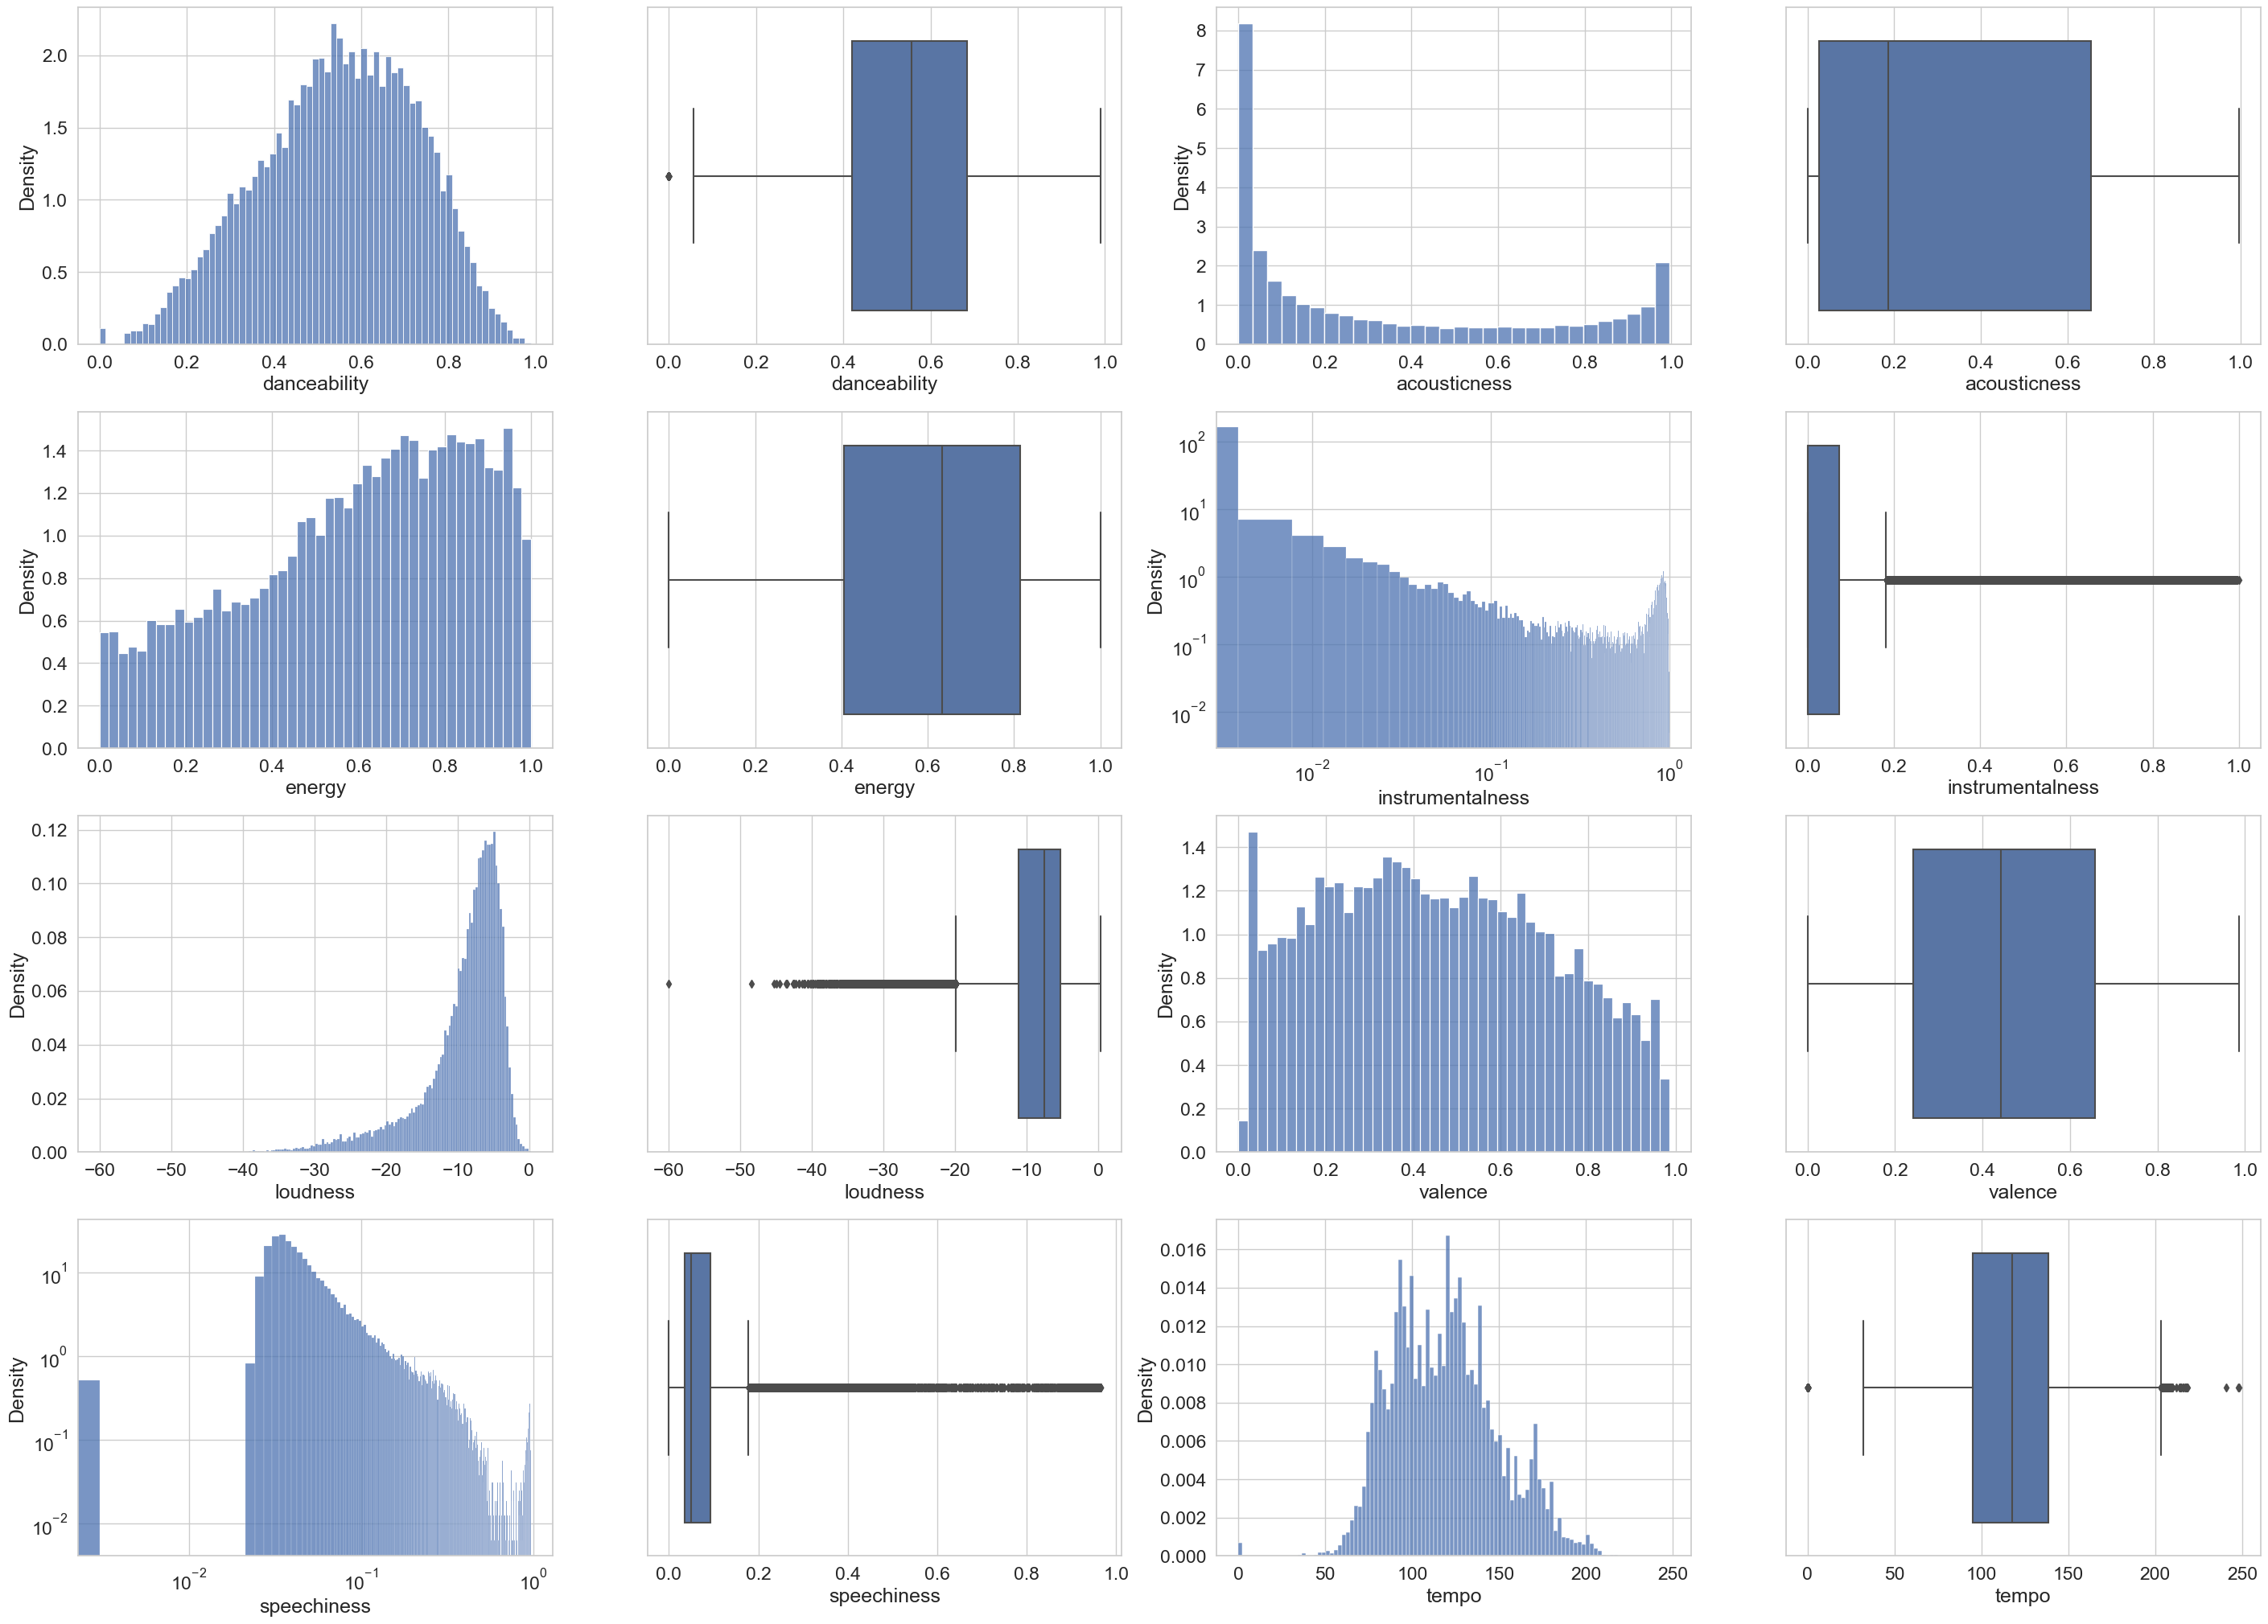

In [115]:
fig, axes = plt.subplots(4, 4, figsize = (35, 25))
sns.histplot(ax = axes[0, 0], data = audio_features, x = 'danceability', stat = 'density')
sns.boxplot(ax = axes[0, 1], data = audio_features, x = 'danceability')

sns.histplot(ax = axes[1, 0], data = audio_features, x = 'energy', stat = 'density')
sns.boxplot(ax = axes[1, 1], data = audio_features, x = 'energy')

sns.histplot(ax = axes[2, 0], data = audio_features, x = 'loudness', stat = 'density')
sns.boxplot(ax = axes[2, 1], data = audio_features, x = 'loudness')

sns.histplot(ax = axes[3, 0], data = audio_features, x = 'speechiness', stat = 'density')
sns.boxplot(ax = axes[3, 1], data = audio_features, x = 'speechiness')

sns.histplot(ax = axes[0, 2], data = audio_features, x = 'acousticness', stat = 'density')
sns.boxplot(ax = axes[0, 3], data = audio_features, x = 'acousticness')

sns.histplot(ax = axes[1, 2], data = audio_features, x = 'instrumentalness', stat = 'density')
sns.boxplot(ax = axes[1, 3], data = audio_features, x = 'instrumentalness')

sns.histplot(ax = axes[2, 2], data = audio_features, x = 'valence', stat = 'density')
sns.boxplot(ax = axes[2, 3], data = audio_features, x = 'valence')

sns.histplot(ax = axes[3, 2], data = audio_features, x = 'tempo', stat = 'density')
sns.boxplot(ax = axes[3, 3], data = audio_features, x = 'tempo')
axes[3, 0].set(xscale = 'log', yscale = 'log')
axes[1, 2].set(xscale = 'log', yscale = 'log')

<AxesSubplot: xlabel='time_signature', ylabel='id'>

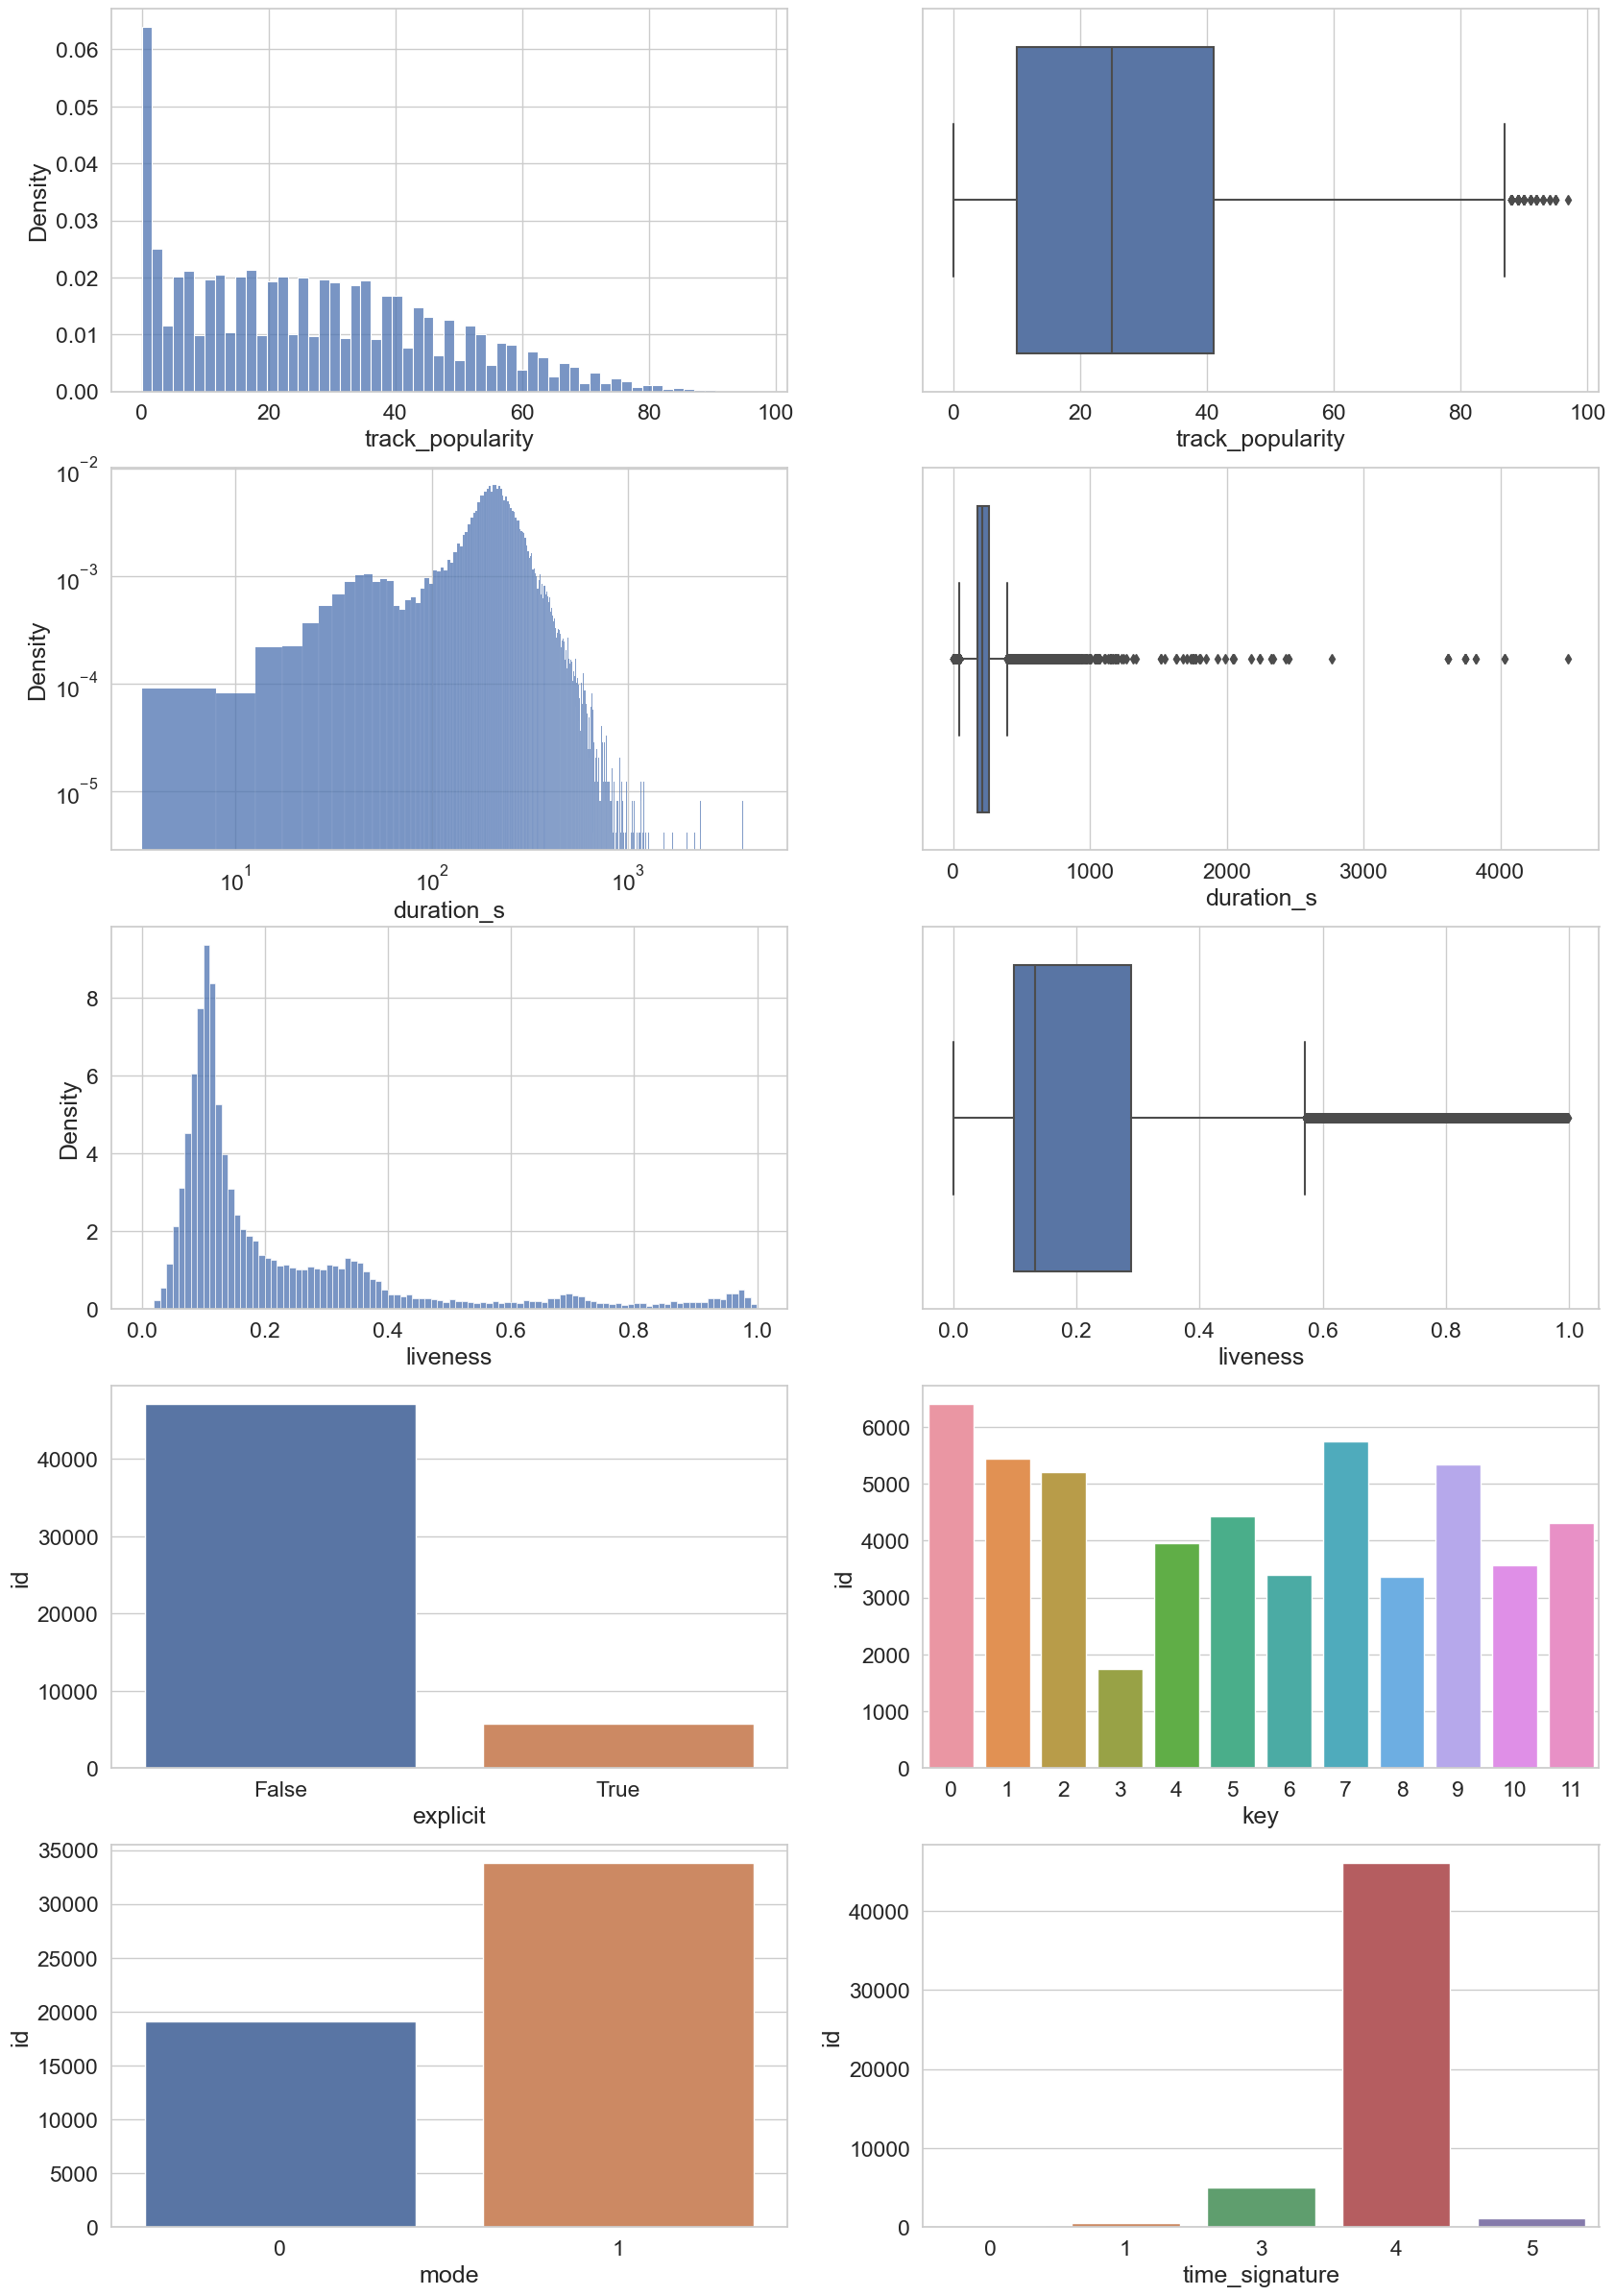

In [116]:
fig, axes = plt.subplots(5, 2, figsize = (20, 30))
sns.histplot(ax = axes[0, 0], data = audio_features, x = 'track_popularity', stat = 'density')
sns.boxplot(ax = axes[0, 1], data = audio_features, x = 'track_popularity')

sns.histplot(ax = axes[1, 0], data = audio_features, x = 'duration_s', stat = 'density')
sns.boxplot(ax = axes[1, 1], data = audio_features, x = 'duration_s')
axes[1, 0].set(xscale = 'log', yscale = 'log')

sns.histplot(ax = axes[2, 0], data = audio_features, x = 'liveness', stat = 'density')
sns.boxplot(ax = axes[2, 1], data = audio_features, x = 'liveness')

sns.barplot(ax = axes[3, 0], data = exp_cnt, x = exp_cnt.index, y = 'id')
sns.barplot(ax = axes[3, 1], data = key_cnt, x = key_cnt.index, y = 'id')
sns.barplot(ax = axes[4, 0], data = mode_cnt, x = mode_cnt.index, y = 'id')
sns.barplot(ax = axes[4, 1], data = ts_cnt, x = ts_cnt.index, y = 'id')

In [117]:
# one-hot encoding mode and explicit
from sklearn.preprocessing import OneHotEncoder

af_corr_df = audio_features
enc = OneHotEncoder()
encoded_cols = enc.fit_transform(af_corr_df[['explicit', 'mode']]).toarray()
print(enc.categories_)
enc_df = pd.DataFrame(encoded_cols, columns = ['explicit_false', 'explicit_true', 'mode_minor', 'mode_major'])
enc_df.head()

[array(['False', 'True'], dtype=object), array([0, 1])]


,explicit_false,explicit_true,mode_minor,mode_major
0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0


In [118]:
af_corr_df = af_corr_df.merge(enc_df, left_index = True, right_index = True)
af_corr_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature,genre,explicit,artist_name,track_popularity,duration_s,explicit_false,explicit_true,mode_minor,mode_major
0,0.492,0.791,11,-5.045,1,0.0703,0.00816,0.000019,0.110,0.585,144.363,audio_features,0LJIVYOer8mlCmTrKoP9Kh,spotify:track:0LJIVYOer8mlCmTrKoP9Kh,https://api.spotify.com/v1/tracks/0LJIVYOer8ml...,https://api.spotify.com/v1/audio-analysis/0LJI...,4,jazz,False,Michael Bublé,54,218.391,1.0,0.0,0.0,1.0
1,0.278,0.354,5,-6.647,0,0.0372,0.50200,0.001240,0.309,0.090,121.803,audio_features,3xZFuVIvzqBImEYJydRkp9,spotify:track:3xZFuVIvzqBImEYJydRkp9,https://api.spotify.com/v1/tracks/3xZFuVIvzqBI...,https://api.spotify.com/v1/audio-analysis/3xZF...,3,jazz,False,Michael Bublé,47,208.866,1.0,0.0,1.0,0.0
2,0.509,0.457,6,-6.021,1,0.0381,0.39800,0.000000,0.104,0.521,116.472,audio_features,1ugWQPtI7SNYDXqEwuEjVm,spotify:track:1ugWQPtI7SNYDXqEwuEjVm,https://api.spotify.com/v1/tracks/1ugWQPtI7SNY...,https://api.spotify.com/v1/audio-analysis/1ugW...,4,jazz,False,Michael Bublé,52,185.531,1.0,0.0,0.0,1.0
3,0.401,0.712,8,-4.518,1,0.0300,0.03710,0.001890,0.091,0.561,84.343,audio_features,4BECSdUBaiMX0dNmLHr0kZ,spotify:track:4BECSdUBaiMX0dNmLHr0kZ,https://api.spotify.com/v1/tracks/4BECSdUBaiMX...,https://api.spotify.com/v1/audio-analysis/4BEC...,4,jazz,False,Michael Bublé,53,197.755,1.0,0.0,0.0,1.0
4,0.506,0.612,11,-6.297,1,0.0607,0.03010,0.000000,0.116,0.527,139.931,audio_features,7zqznhNk8DZbwo8fWIF82V,spotify:track:7zqznhNk8DZbwo8fWIF82V,https://api.spotify.com/v1/tracks/7zqznhNk8DZb...,https://api.spotify.com/v1/audio-analysis/7zqz...,3,jazz,False,Michael Bublé,51,143.386,1.0,0.0,0.0,1.0


/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_26509/2231766332.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(af_corr_df.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')


<AxesSubplot: >

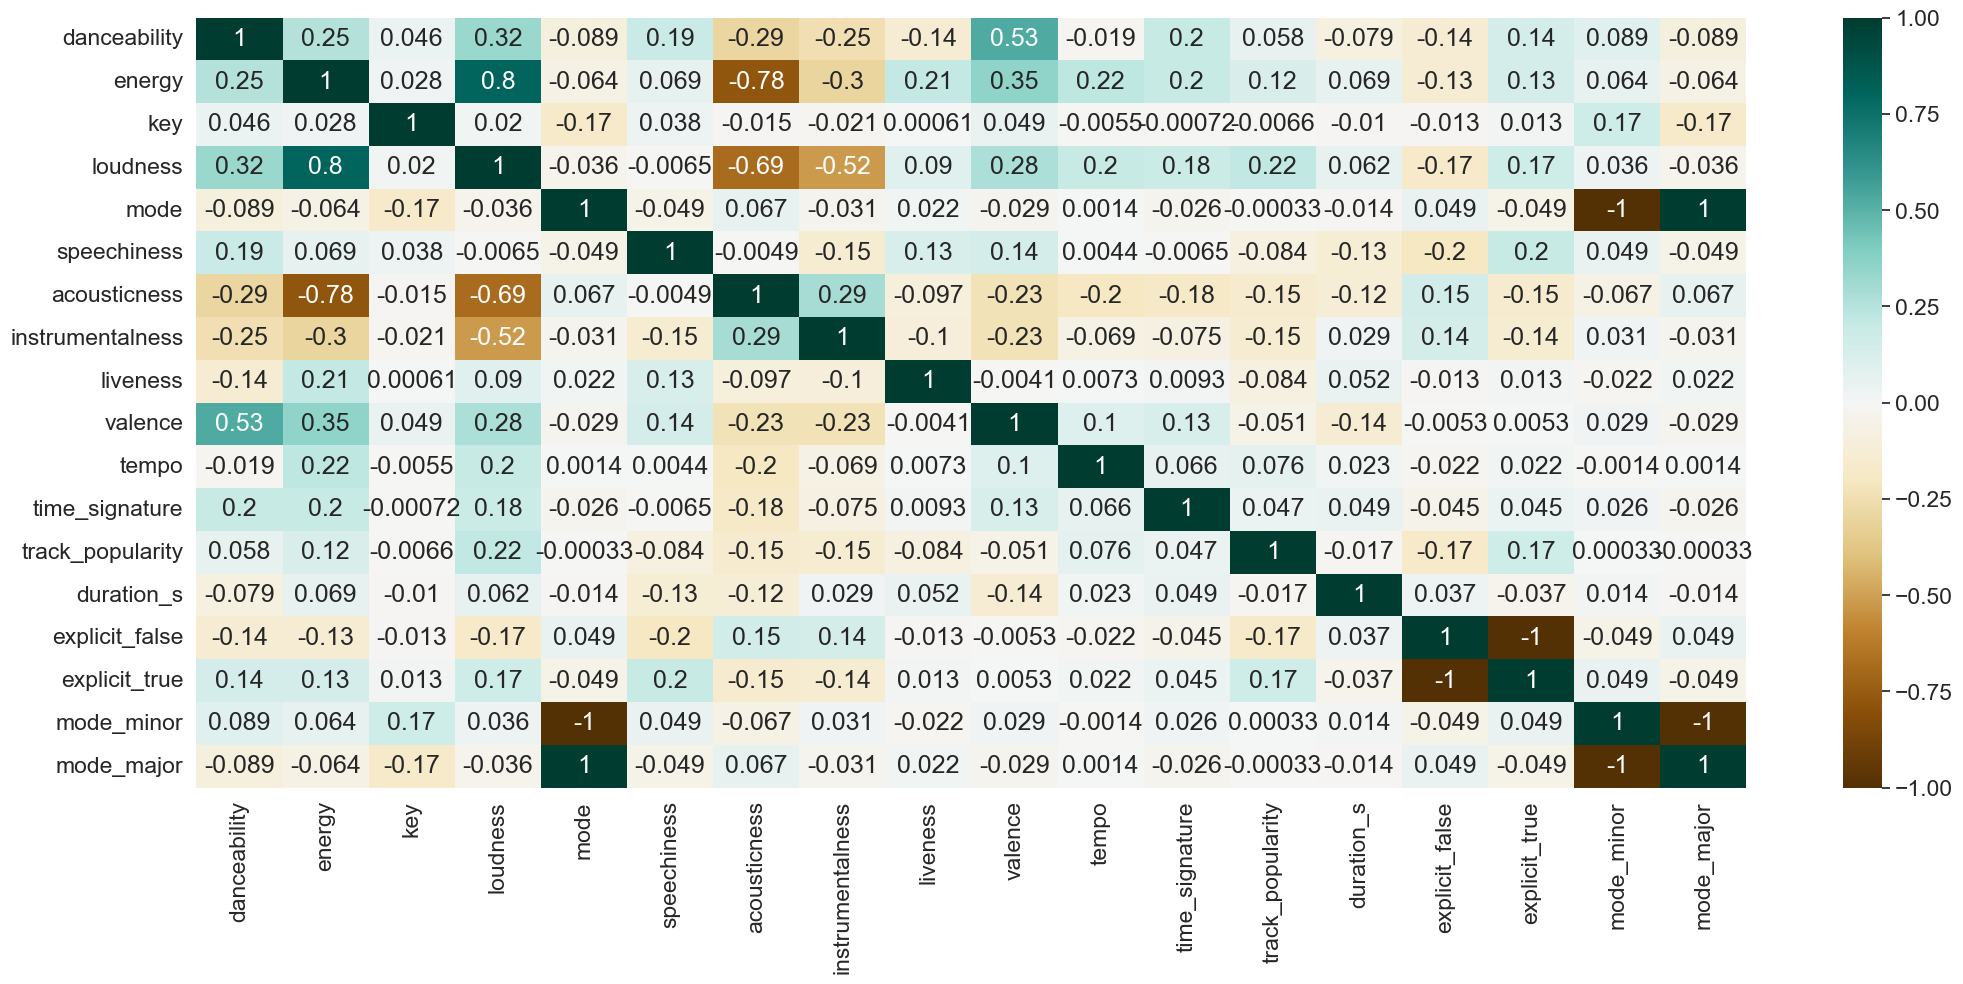

In [119]:
plt.figure(figsize = (25, 10))
sns.heatmap(af_corr_df.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')

## Feature Engineering

In terms checking for multicollinearity, we're going to use 0.7/0.8 as our cutoff. 

- Energy and loudness have a high correlation of 0.8
- Energy and acousticness have a high correlation of -0.78

Thus, we will be dropping both loudness and acousticness since they're also both not useful to determining mood classes. 

We'll also be dropping liveness and duration because they have too many outliers. 

Since explicit has a lot of 'False', it seems that it won't add much to figuring out mood classes. 

Although instrumentalness and speechiness don't have much correlation with each other, we'll be dropping both of them as they have too many outliers. 

Columns we'll be keeping: danceability, energy, mode, valence, tempo, time_signature, key. 

## Potential Transformations

- We will have to one-hot encode the mode feature. 
- We'll have to standardize the other numerical features

In [120]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [121]:
audio_features_ml = audio_features[['danceability', 'energy', 'mode', 'valence', 'tempo', 'time_signature', 'key']]

In [122]:
# encoding and scaling features
enc = OneHotEncoder()
encoded_cols = enc.fit_transform(audio_features_ml[['mode']]).toarray()
print(enc.categories_)
enc_df = pd.DataFrame(encoded_cols, columns = ['mode_minor', 'mode_major'])
enc_df.head()

[array([0, 1])]


,mode_minor,mode_major
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [123]:
audio_features_ml = audio_features_ml.merge(enc_df, left_index = True, right_index = True) \
    .drop(['mode'], axis = 1)
audio_features_ml.head()

,danceability,energy,valence,tempo,time_signature,key,mode_minor,mode_major
0,0.492,0.791,0.585,144.363,4,11,0.0,1.0
1,0.278,0.354,0.090,121.803,3,5,1.0,0.0
2,0.509,0.457,0.521,116.472,4,6,0.0,1.0
3,0.401,0.712,0.561,84.343,4,8,0.0,1.0
4,0.506,0.612,0.527,139.931,3,11,0.0,1.0


In [124]:
numeric_columns = ['danceability', 'energy', 'valence', 'tempo']
cat_columns = ['time_signature', 'mode_minor', 'mode_major']

In [125]:
scaler = StandardScaler()
scaled_cols = pd.DataFrame(scaler.fit_transform(audio_features_ml[numeric_columns]))
audio_features_ml[numeric_columns] = scaled_cols
audio_features_ml.head()

,danceability,energy,valence,tempo,time_signature,key,mode_minor,mode_major
0,-0.297043,0.745460,0.501400,0.835963,4,11,0.0,1.0
1,-1.477316,-0.902766,-1.423987,0.097770,3,5,1.0,0.0
2,-0.203283,-0.514282,0.252461,-0.076667,4,6,0.0,1.0
3,-0.798935,0.447497,0.408048,-1.127971,4,8,0.0,1.0
4,-0.219829,0.070329,0.275799,0.690942,3,11,0.0,1.0


## Types of Clustering
https://developers.google.com/machine-learning/clustering/clustering-algorithms 

## Gaussian Mixture Models (GMM)
https://aabkn.github.io/GMM_visually_explained 

### Motivation
K-means clustering isn't flexible enough to account for non-spherical clusters and tries to force-fit data into them. This results in a mixing of cluster assignments where the resulting clusters overlap. 

It's also a hard clustering method–the distance between the centroid and the most distant point of the cluster acts as a hard cutoff for cluster assignment. 

It can't measure probability or uncertainty of a cluster assignment. 

### What is GMM?
It is a clustering technique that attempts to find a mixture of Gaussian probability distributions that best model any input dataset. It assumes that data is composed of different Gaussian distributions. 

It employs the expectation-maximization (EM) algorithm to cluster points and assign probabilities of belonging to a cluster to each point:
1. Choose start guesses for location and shape
2. Repeat until converged:
    1. E-step: For each observation, find weights encoding probability of membership in each cluster
    2. M-step: For each cluster, update its parameters (mean, variance, mixture parameter) making use of the weights (probability of membership). This is updated in order to take steps to maximize the likelihood of the points belonging to the cluster. 

#### What is the Expectation-Maximization (EM) Algorithm?

If we know which component a point came from (class label), we can learn the parameters of each component independently. On the other hand, if we know the parameters of all components, we can assign points to their most probable class. 

This leads us to the idea that we can iteratively update the parameters and class labels based on previous estimates of them. 

The EM algorithm does exactly that except it uses probabilities of a point belonging to a cluster. 

There are 2 main components that make up the EM algorithm. The expectation component calculates the posterior probability that a point belongs to cluster k given the cluster is a Gaussian distribution with a set of parameters.

The maximization component first involves taking the expected value of the log-likelihood given the posterior distribution of the cluster assignments. This is because in GMM, uncertainty is accounted for when doing cluster assignments and thus there is randomness in cluster assignments. To estimate the log-likelihood, we take the expectation of it and then maximize on it to find the best parameters that fit the Gaussian mixture distribution and can thus best model the data. 

### Assumptions
- The data is assumed to be of a Gaussian mixture distrbution
- The observations in the data are independent

In [126]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

In [127]:
import sklearn.model_selection as ms
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Silhouette Score Plot

In [ ]:
s_score = []
n_clusters = list(range(2, 11))
for n in n_clusters: 
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    labels = gmm_model.fit_predict(audio_features_ml)
    s_score.append(silhouette_score(audio_features_ml, labels, metric = 'euclidean'))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 21), s_score, 'bo-', alpha = 1, color = 'black')
plt.title('Silhouette plot')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

## BIC Score Plot 

In [128]:
bic_score = []
n_clusters = list(range(2, 11))
for n in n_clusters: 
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    model = gmm_model.fit(audio_features_ml)
    bic_score.append(model.bic(audio_features_ml))

/var/folders/6g/t90358yn4ynclrp0db92rf1c0000gn/T/ipykernel_26509/2131860362.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2, 11), bic_score, 'bo-', alpha = 1, color = 'black')


Text(0, 0.5, 'Score')

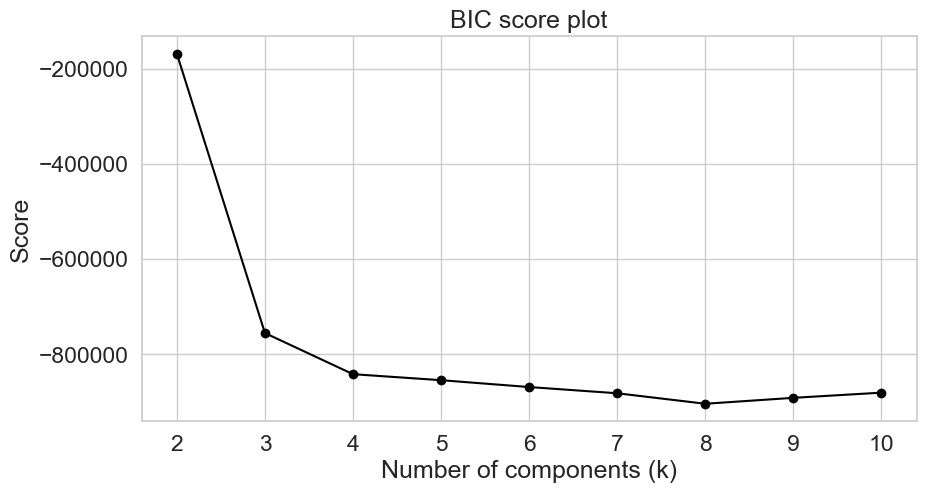

In [130]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 11), bic_score, 'bo-', alpha = 1, color = 'black')
plt.title('BIC score plot')
plt.xlabel('Number of components (k)')
plt.ylabel('Score')

## Results (n = 2)

In [131]:
gmm_model_1 = GaussianMixture(2, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels = gmm_model_1.fit_predict(audio_features_ml)

In [132]:
audio_features_ml['cluster'] = labels + 1
audio_features_ml['mode'] = audio_features['mode']
audio_features_ml.head()

,danceability,energy,valence,tempo,time_signature,key,mode_minor,mode_major,cluster,mode
0,-0.297043,0.745460,0.501400,0.835963,4,11,0.0,1.0,1,1
1,-1.477316,-0.902766,-1.423987,0.097770,3,5,1.0,0.0,2,0
2,-0.203283,-0.514282,0.252461,-0.076667,4,6,0.0,1.0,1,1
3,-0.798935,0.447497,0.408048,-1.127971,4,8,0.0,1.0,1,1
4,-0.219829,0.070329,0.275799,0.690942,3,11,0.0,1.0,2,1


In [133]:
numeric_columns = list(audio_features_ml.columns[:4])
cluster_1 = audio_features_ml[audio_features_ml['cluster'] == 1]
cluster_2 = audio_features_ml[audio_features_ml['cluster'] == 2]

/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/huongngo/opt/anaconda3/envs/song_rec/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


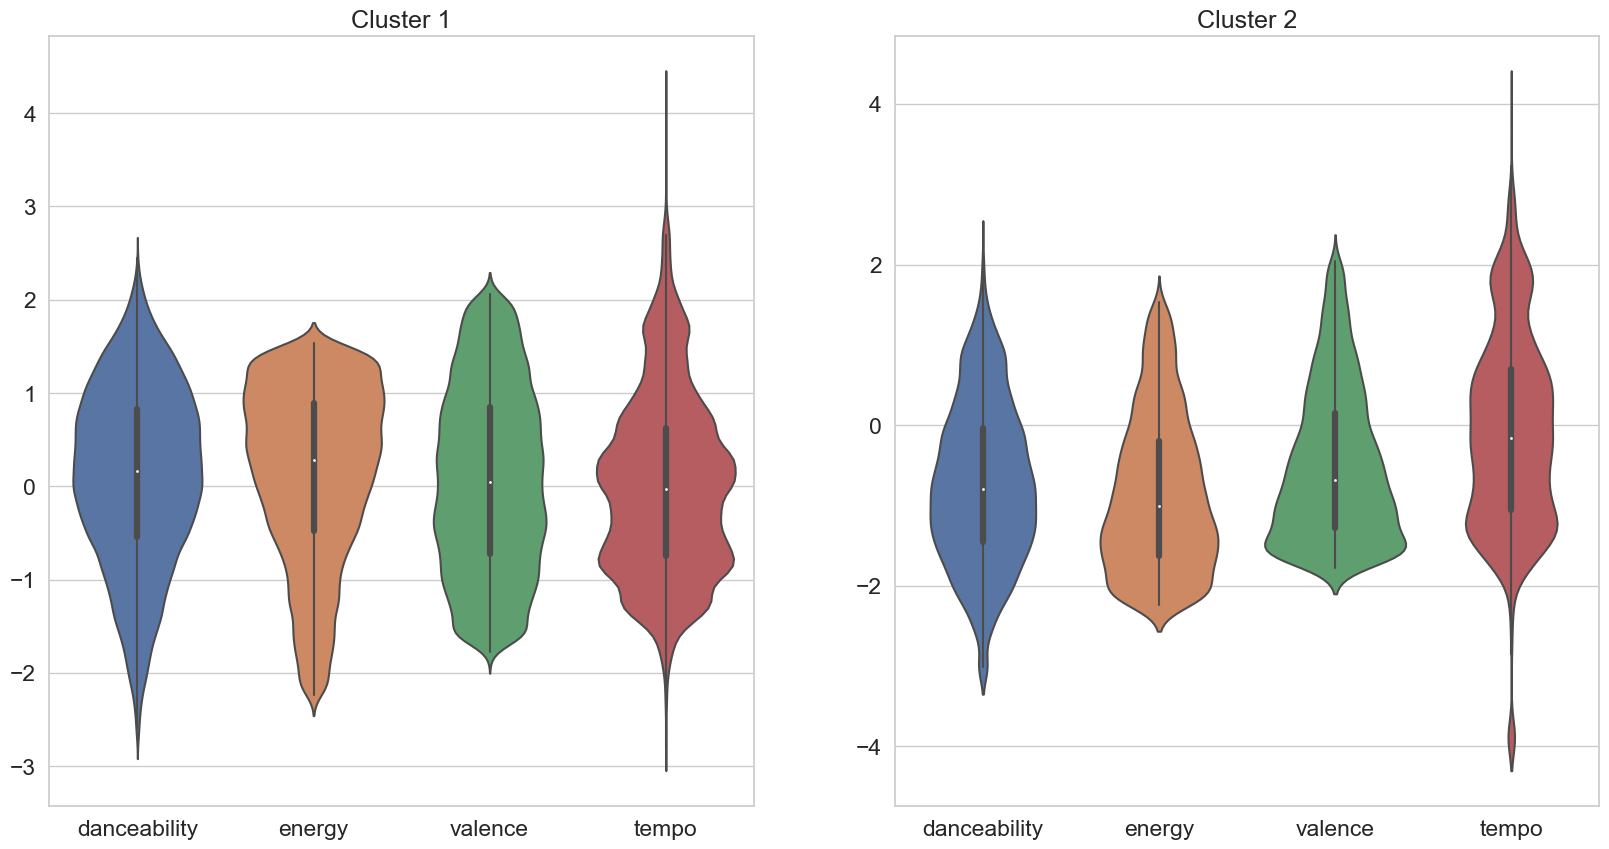

In [134]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
sns.violinplot(ax = axes[0], data = cluster_1[numeric_columns])
axes[0].title.set_text('Cluster 1')
sns.violinplot(ax = axes[1], data = cluster_2[numeric_columns])
axes[1].title.set_text('Cluster 2')

In [135]:
cluster_1_key_mode_cnt = pd.DataFrame(cluster_1.groupby(['key', 'mode']).count()['cluster'])
cluster_2_key_mode_cnt = pd.DataFrame(cluster_2.groupby(['key', 'mode']).count()['cluster'])

In [138]:
cluster_1_key_mode_cnt

cluster
key mode         
0   0        1093
    1        4470
1   0        1438
    1        3479
2   0         903
    1        3582
3   0         543
    1         914
4   0        1856
    1        1546
5   0        1837
    1        1949
6   0        1459
    1        1536
7   0        1131
    1        3882
8   0         787
    1        2135
9   0        1983
    1        2663
10  0        1633
    1        1422
11  0        2195
    1        1645

In [139]:
cluster_2_key_mode_cnt

cluster
key mode         
0   0         174
    1         664
1   0         130
    1         394
2   0         196
    1         525
3   0          84
    1         202
4   0         277
    1         281
5   0         241
    1         406
6   0         168
    1         240
7   0         152
    1         575
8   0         110
    1         324
9   0         295
    1         394
10  0         173
    1         343
11  0         228
    1         240

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 15))
sns.barplot(ax = axes[0], data = cluster_1_mode_cnt, x = cluster_1_mode_cnt.index, y = 'cluster')
axes[0].title.set_text('Cluster 1')
sns.barplot(ax = axes[1], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[1].title.set_text('Cluster 2')

### Cluster 1 -> Angry + Sad + Calm?

In [ ]:
s_score_1 = []
n_clusters = list(range(2, 5))
for n in n_clusters: 
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    labels = gmm_model.fit_predict(cluster_1)
    s_score_1.append(silhouette_score(cluster_1, labels, metric = 'euclidean'))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 5), s_score_1, 'bo-', alpha = 1, color = 'black')
plt.title('Silhouette plot')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

In [ ]:
cluster_1_df = cluster_1

In [ ]:
gmm_model_3 = GaussianMixture(3, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels_3 = gmm_model_3.fit_predict(cluster_1_df)

In [ ]:
cluster_1_df.head()

In [ ]:
cluster_1_df['cluster'] = labels_3 + 1
cluster_1_df.head()

In [ ]:
temp_1 = cluster_1_df[cluster_1_df['cluster'] == 1]
temp_2 = cluster_1_df[cluster_1_df['cluster'] == 2]
temp_3 = cluster_1_df[cluster_1_df['cluster'] == 3]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
sns.violinplot(ax = axes[0], data = temp_1[numeric_columns])
axes[0].title.set_text('Cluster 1')
sns.violinplot(ax = axes[1], data = temp_2[numeric_columns])
axes[1].title.set_text('Cluster 2')
sns.violinplot(ax = axes[2], data = temp_3[numeric_columns])
axes[2].title.set_text('Cluster 3')

In [ ]:
cluster_1_mode_cnt = pd.DataFrame(temp_1.groupby(['mode']).count()['cluster'])
cluster_2_mode_cnt = pd.DataFrame(temp_2.groupby(['mode']).count()['cluster'])
cluster_3_mode_cnt = pd.DataFrame(temp_3.groupby(['mode']).count()['cluster'])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 15))
sns.barplot(ax = axes[0], data = cluster_1_mode_cnt, x = cluster_1_mode_cnt.index, y = 'cluster')
axes[0].title.set_text('Cluster 1')
sns.barplot(ax = axes[1], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[1].title.set_text('Cluster 2')
sns.barplot(ax = axes[2], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[2].title.set_text('Cluster 3')

### Cluster 2 -> Happy + Angry?

In [ ]:
s_score_2 = []
n_clusters = list(range(2, 5))
for n in n_clusters: 
    gmm_model = GaussianMixture(n, random_state = 2002, init_params = 'k-means++', n_init = 10)
    labels = gmm_model.fit_predict(cluster_2)
    s_score_2.append(silhouette_score(cluster_2, labels, metric = 'euclidean'))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(range(2, 5), s_score_2, 'bo-', alpha = 1, color = 'black')
plt.title('Silhouette plot')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

In [ ]:
cluster_2_df = cluster_2

In [ ]:
gmm_model_4 = GaussianMixture(2, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels_4 = gmm_model_4.fit_predict(cluster_2_df)

In [ ]:
cluster_2_df.head()

In [ ]:
cluster_2_df['cluster'] = labels_4 + 1
cluster_2_df.head()

In [ ]:
temp_4 = cluster_2_df[cluster_2_df['cluster'] == 1]
temp_5 = cluster_2_df[cluster_2_df['cluster'] == 2]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
sns.violinplot(ax = axes[0], data = temp_4[numeric_columns])
axes[0].title.set_text('Cluster 1')
sns.violinplot(ax = axes[1], data = temp_5[numeric_columns])
axes[1].title.set_text('Cluster 2')

In [ ]:
cluster_1_mode_cnt = pd.DataFrame(temp_4.groupby(['mode']).count()['cluster'])
cluster_2_mode_cnt = pd.DataFrame(temp_5.groupby(['mode']).count()['cluster'])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 15))
sns.barplot(ax = axes[0], data = cluster_1_mode_cnt, x = cluster_1_mode_cnt.index, y = 'cluster')
axes[0].title.set_text('Cluster 1')
sns.barplot(ax = axes[1], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[1].title.set_text('Cluster 2')

## Previous Results (n = 4)

In [ ]:
gmm_model_4 = GaussianMixture(4, random_state = 2002, init_params = 'k-means++', n_init = 10)
labels = gmm_model_4.fit_predict(audio_features_ml)

In [ ]:
audio_features_ml['cluster'] = labels + 1
audio_features_ml['mode'] = audio_features['mode']
audio_features_ml.head()

In [ ]:
numeric_columns = list(audio_features_ml.columns[:4])
cluster_1 = audio_features_ml[audio_features_ml['cluster'] == 1]
cluster_2 = audio_features_ml[audio_features_ml['cluster'] == 2]
cluster_3 = audio_features_ml[audio_features_ml['cluster'] == 3]
cluster_4 = audio_features_ml[audio_features_ml['cluster'] == 4]

In [ ]:
cluster_1.head()

## Analysis of Clusters

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10))
sns.violinplot(ax = axes[0, 0], data = cluster_1[numeric_columns])
axes[0, 0].title.set_text('Cluster 1')
sns.violinplot(ax = axes[1, 0], data = cluster_2[numeric_columns])
axes[1, 0].title.set_text('Cluster 2')
sns.violinplot(ax = axes[0, 1], data = cluster_3[numeric_columns])
axes[0, 1].title.set_text('Cluster 3')
sns.violinplot(ax = axes[1, 1], data = cluster_4[numeric_columns])
axes[1, 1].title.set_text('Cluster 4')

In [ ]:
cluster_1_mode_cnt = pd.DataFrame(cluster_1.groupby(['mode']).count()['cluster'])
cluster_2_mode_cnt = pd.DataFrame(cluster_2.groupby(['mode']).count()['cluster'])
cluster_3_mode_cnt = pd.DataFrame(cluster_3.groupby(['mode']).count()['cluster'])
cluster_4_mode_cnt = pd.DataFrame(cluster_4.groupby(['mode']).count()['cluster'])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
sns.barplot(ax = axes[0, 0], data = cluster_1_mode_cnt, x = cluster_1_mode_cnt.index, y = 'cluster')
axes[0, 0].title.set_text('Cluster 1')
sns.barplot(ax = axes[1, 0], data = cluster_2_mode_cnt, x = cluster_2_mode_cnt.index, y = 'cluster')
axes[1, 0].title.set_text('Cluster 2')
sns.barplot(ax = axes[0, 1], data = cluster_3_mode_cnt, x = cluster_3_mode_cnt.index, y = 'cluster')
axes[0, 1].title.set_text('Cluster 3')
sns.barplot(ax = axes[1, 1], data = cluster_4_mode_cnt, x = cluster_4_mode_cnt.index, y = 'cluster')
axes[1, 1].title.set_text('Cluster 4')

If we use `reset_index()`, we can turn any indices into columns

In [ ]:
cluster_stats = audio_features_ml.groupby(['cluster']) \
    .describe()[numeric_columns]
cluster_stats = cluster_stats.T.reset_index()
cluster_stats = cluster_stats.rename(columns = {'level_0': 'feature', 'level_1': 'statistic'})
cluster_stats

In [ ]:
for feature in cluster_stats['feature'].unique():
    print(f'Feature: {feature}')
    temp = cluster_stats[cluster_stats['feature'] == feature]
    for i in range(1, 5):
        print(f'Cluster {i}')
        median = temp[temp['statistic'] == '50%'][i].iloc[0]
        iqr = temp[temp['statistic'] == '75%'][i].iloc[0] - temp[temp['statistic'] == '25%'][i].iloc[0]
        min = temp[temp['statistic'] == 'min'][i].iloc[0]
        max = temp[temp['statistic'] == 'max'][i].iloc[0]
        print(f'Median: {(median - min) / (max - min)}')
        print(f'IQR: {(iqr - min) / (max - min)}')
    print('')


In [ ]:
for i in range(1, 5):
    print(f'Cluster {i}')
    temp = cluster_stats.loc[:, :i]
    for feature in temp['feature'].unique():
        print(f'Feature: {feature}')
        temp_2 = temp[temp['feature'] == feature]
        median = temp_2[temp_2['statistic'] == '50%'][i].iloc[0]
        iqr = temp_2[temp_2['statistic'] == '75%'][i].iloc[0] - temp_2[temp_2['statistic'] == '25%'][i].iloc[0]
        min = temp_2[temp_2['statistic'] == 'min'][i].iloc[0]
        max = temp_2[temp_2['statistic'] == 'max'][i].iloc[0]
        print(f'Median: {(median - min) / (max - min)}')
        print(f'IQR: {(iqr - min) / (max - min)}')
    print('')

In [ ]:
audio_features.head()

In [ ]:
audio_features = audio_features.merge(audio_features_ml['cluster'], how = 'inner', left_index = True, right_index = True)

In [ ]:
audio_features.head()

In [ ]:
cluster_1_full = audio_features[audio_features['cluster'] == 1]
cluster_2_full = audio_features[audio_features['cluster'] == 2]
cluster_3_full = audio_features[audio_features['cluster'] == 3]
cluster_4_full = audio_features[audio_features['cluster'] == 4]

In [ ]:
cluster_1_full[cluster_1_full['genre'] == 'classical'].head()

In [ ]:
cluster_1_full[cluster_1_full['genre'] == 'ambient'].head()

In [ ]:
cluster_1_full[cluster_1_full['genre'] == 'jazz'].head()

In [ ]:
pd.DataFrame(audio_features.groupby(['cluster']).value_counts(['genre'])).T

## Analysis of Clusters

### Danceability
- 4 > 2 > 3 > 1 (Median)
- 3 > 1 > 4 > 2 (Variation)

### Energy
- 4 > 2 > 1 > 3 (Median)
- 3 > 2 > 1 > 4 (Variation)

### Valence
- 4 > 2 > 3 > 1 (Median)
- 3 > 4 > 2 > 1 (Variation)

### Tempo
- 3 > 4 > 1 > 2 (Median)
- 3 > 4 > 1 > 2 (Variation)



### Cluster 1
- Median tempo value is highest
- Tempo > Danceability > Energy > Valence

### Cluster 2
- Median energy value is highest
- Energy > Danceability > Valence > Tempo

### Cluster 3
- Median tempo value is highest
- Tempo > Danceability > Valence > Energy

### Cluster 4
- Median tempo value is highest
- Energy > Danceability > Valence > Tempo